# ML MODELS PROBE FOR TITANIC DISASTER PROBLEM
<p>Made By Santiago Cadena A. </p>

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression,Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import r_regression
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix




[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Work stages find the solution:
1. Prepare, clean the data.
2. Identify patterns: correlation beween variables, analyze the data
3. Model and predict the problem
4. Visualize, report and present the problem solving
## Workflow goals
1. Classifying : Understand the implication between the classes.
2. Correlating: Find the features that contribute better than others.
3. Converting: Text to data
4. Correcting: Detect outliers, discard features
5. Creating: Create new features
6. Charging: Choose correct visualization charts for analyze them

In [2]:
def convert_dataset(df):
    df['Embarked'] = df['Embarked'].map({'C':0,'Q':1,'S':2})#ordinal
    df['Sex'] =df['Sex'].map({'male':0,'female':1}) #nominal
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Anyone": 5} #ordinal
    df['Title'] = df['Title'].map(title_mapping) 
    return df

#load and combine data: training and testing. For make the changes in both. 
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")


In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
passengerId=df_test.iloc[:,0]
y_test=pd.read_csv("gender_submission.csv")
y_test=y_test.iloc[:,1]
#delete insignificat features
df_test=df_test.drop(["PassengerId","Ticket","Cabin"],axis=1)
df_train=df_train.drop(["PassengerId","Ticket","Cabin"],axis=1)

combined=[df_train,df_test]

#see which features have null values for fix them after
print("trained dataframe:",combined[0].columns[combined[0].isna().any()])  
print("test dataframe:",combined[1].columns[combined[1].isna().any()] )  



trained dataframe: Index(['Age', 'Embarked'], dtype='object')
test dataframe: Index(['Age', 'Fare'], dtype='object')


### Analysis by single features (Pclass, Embarkation type, Sex)

In [6]:
#P class incide
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [7]:
#Embarkation incide a little
df_train[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [8]:
#Sex incide
df_train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived',ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


- Sex ~ Survival
- PClass ~ Survival 
- Embarkation ~ Survival 

### Analysis by visualizating features (age,fare)



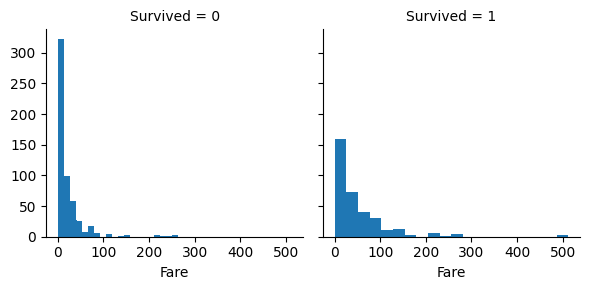

In [9]:

g=sns.FacetGrid(df_train,col="Survived")
g.map(plt.hist,'Age',bins=20) #bins are the number of samples among the entire age range
g.map(plt.hist,'Fare',bins=20) 

Similar behaviour for survived and unsurvived, no correlation.

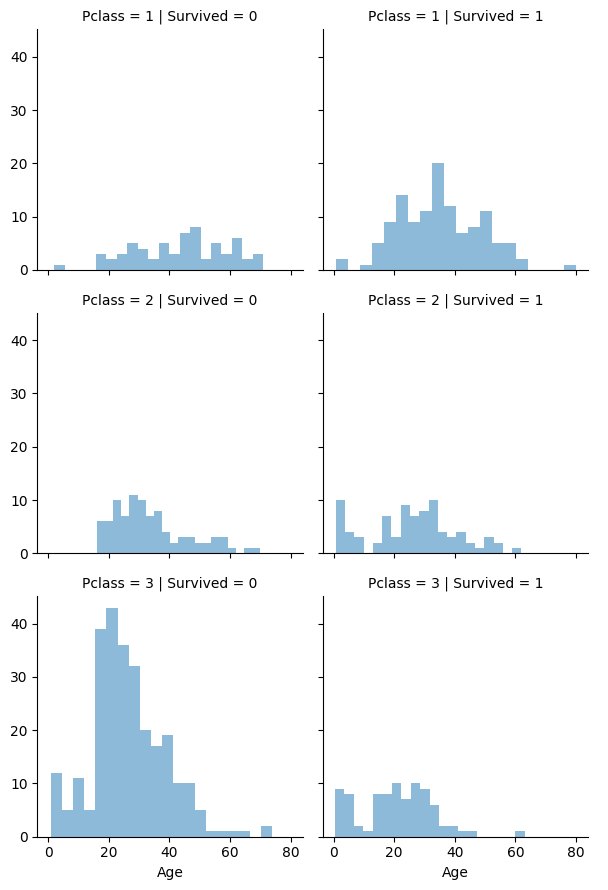

In [10]:
#age and fare
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

- The lower the class, most probability of survival
- People of approximate 25 are the most probable to survive
- In class 2 and 1 most of the people who didn´t surive were from 20 to 30 

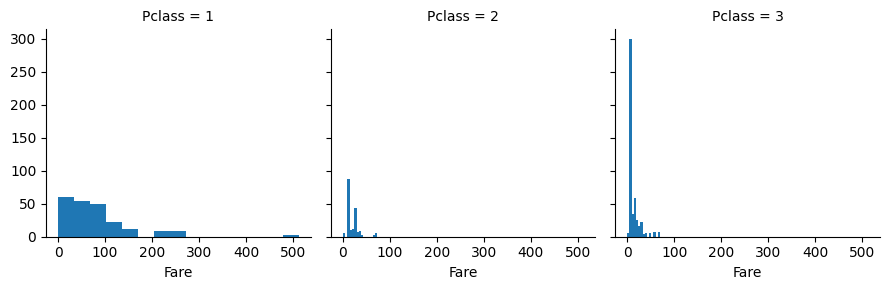

In [11]:
#correlation between the class and fare
g=sns.FacetGrid(df_train,col="Pclass")
g.map(plt.hist,'Fare',bins=15) 
g.map(plt.hist,'Fare',bins=15) 
g.map(plt.hist,'Fare',bins=15) 


We see a left-shifted distribution, hence it's appropiate use a metric like the median and not the mean for filling the Nan values in Fare

### Filling up Data

In [12]:
#Fare in test data
fare_group=df_test[['Fare','Pclass']].groupby('Pclass').median()
df_test['Fare'] = combined[0].apply(lambda x: fare_group[x['Pclass']] if np.isnan(x['Fare']) else x['Fare'],axis=1)

The Name feature do contributte, due to the title 'Mr','Miss','Mrs' could be of utility in the survival classification. Also can be of interest in filling Fare, Age NaN values. 

In [13]:
for dataset in combined:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(df_train['Title'], df_train['Sex'])


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
C:\Users\santi\AppData\Local\Temp\ipykernel_10036\2013435651.py:2: SyntaxWarning: invalid escape sequence '\.'
  dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [14]:
#The most weighted titles are : "Mr","Miss","Mrs","Master".
print(df_train.head())
mostf_titles={"Mr":['Capt','Col','Countess','Don','Major','Cls','Don','Dr','Mr'],"Miss":['Lady','Mlle','Miss'],"Mrs":['Mme','Ms','Mrs'],"Master":['Master']}
def insert_title(title):
    for key, values in mostf_titles.items():
        if title in values:
            return key
    return 'Anyone'
for df in combined:
    df['Title']=df['Title'].apply(lambda x: insert_title(x))
    df.drop(['Name'],axis=1,inplace=True)
combined[0][['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived',ascending=False)


   Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch     Fare Embarked Title  
0    male  22.0      1      0   7.2500        S    Mr  
1  female  38.0      1      0  71.2833        C   Mrs  
2  female  26.0      0      0   7.9250        S  Miss  
3  female  35.0      1      0  53.1000        S   Mrs  
4    male  35.0      0      0   8.0500        S    Mr  


,Title,Survived
4,Mrs,0.795276
2,Miss,0.702703
1,Master,0.575000
3,Mr,0.163842
0,Anyone,0.125000


Fill the Nan ages based on the 'Title' aggrupation 

In [15]:
for df in combined:
    age_group =  df.groupby('Title')['Age'].mean()
    age_group = age_group.round(0)
    df['Age'] =  df.apply(lambda x: age_group[x['Title']] if np.isnan(x['Age']) else x['Age'],axis=1)


In [16]:
#complete nan values for embarked in train
most_freq_embark=df_train.Embarked.dropna().mode()[0]
df_train['Embarked'] = df_train['Embarked'].fillna(most_freq_embark)


convert cathegorical to numerical features, then see the heatmap for more correlation if exist

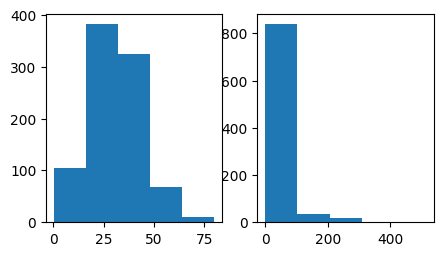

<Axes: >

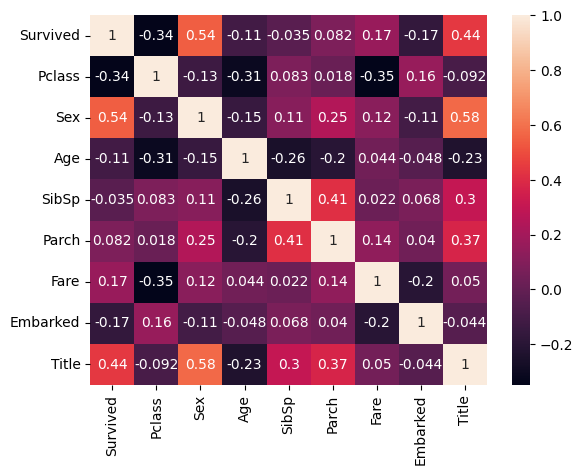

In [17]:
#Divide the 'Age', 'Fare' features in ranges. Good fit 10 and 5 bins for Age and Fare respectively
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.7))
ax1.hist(df_train['Age'],bins=5)
ax2.hist(df_train['Fare'],bins=5)
plt.show()
df_train['Age']=pd.cut(df_train['Age'],5,labels=[1,2,3,4,5])
df_train['Fare']=pd.cut(df_train['Fare'],5,labels=[1,2,3,4,5])
#convert cathegorical to numerical
df_train=convert_dataset(df_train)   
df_test=convert_dataset(df_test)
corr_matrix=df_train.corr()
sns.heatmap(corr_matrix,annot=True)


'SibSp' is correlated with 'Parch' significally, and they don't weight too much to 'Survived'. Hence sum them.

   Survived  Pclass  Sex Age Fare  Embarked  Title  Family_members
0         0       3    0   2    1         2      1               1
1         1       1    1   3    1         0      3               1
2         1       3    1   2    1         2      2               0
3         1       1    1   3    1         2      3               1
4         0       3    0   3    1         2      1               0


C:\Users\santi\AppData\Local\Temp\ipykernel_10036\199106421.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  members= df[['SibSp','Parch']].apply(lambda row: row[0] + row[1], axis=1)
C:\Users\santi\AppData\Local\Temp\ipykernel_10036\199106421.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  members= df[['SibSp','Parch']].apply(lambda row: row[0] + row[1], axis=1)


<Axes: >

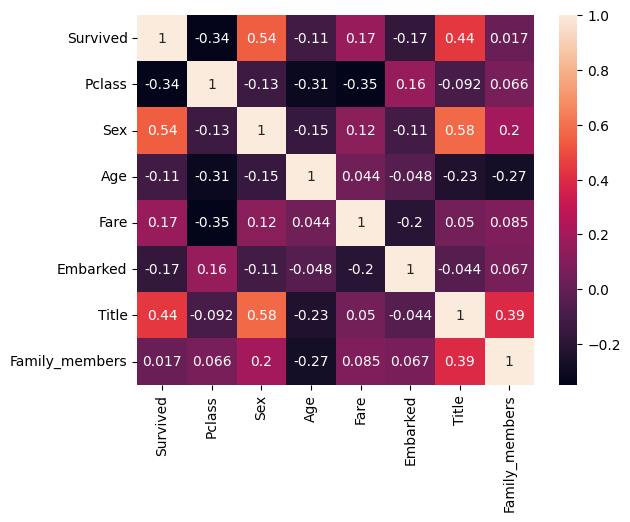

In [18]:
for df in combined:
    members= df[['SibSp','Parch']].apply(lambda row: row[0] + row[1], axis=1)
    df['Family_members']=members
    df.drop(['SibSp','Parch'],axis=1,inplace=True)
print(df_train.head())
corr_matrix=df_train.corr()
sns.heatmap(corr_matrix,annot=True)



# Modelation

For mixed features, i.e cathegorical and numerical these models work: Decision Trees, Naive Bayes (with Gaussian distribution with numeric attributes),KNN. Otherwise it's necessary to try ensemble techniques. 

In [22]:
#Instanciate classifier
X_train=df_train.iloc[:,1:]
y_train=df_train.iloc[:,0]
X_test=df_test
classifiers_names=[
    'SVC',
    'LinearSVC',
    'DecisionTreeClassifier',
    'Perceptron',
    'SGDClassifier',  
    'GaussianNB',
    'KNeighborsClassifier',
    'RandomForestClassifier',
    'MLPClassifier',
    'LogisticRegression'
]
classifiers=[SVC(),LinearSVC(),DecisionTreeClassifier(),Perceptron(),SGDClassifier(),GaussianNB(),KNeighborsClassifier(n_neighbors=10),RandomForestClassifier(),MLPClassifier(),LogisticRegression()]
for i,clf in enumerate(classifiers):
    clf_fitted=clf.fit(X_train,y_train)
    predicted=clf_fitted.predict(X_test)
    confusion=confusion_matrix(y_test,predicted)
    print(f"Test set score for {classifiers_names[i]} model: {clf.score(X_test, y_test):.4f}")
    print(f"Confusion matrix for {classifiers_names[i]} model:\n{confusion}")
    print("-" * 50)  


Test set score for SVC model: 0.6388
Confusion matrix for SVC model:
[[266   0]
 [151   1]]
--------------------------------------------------
Test set score for LinearSVC model: 0.6053
Confusion matrix for LinearSVC model:
[[229  37]
 [128  24]]
--------------------------------------------------
Test set score for DecisionTreeClassifier model: 0.7560
Confusion matrix for DecisionTreeClassifier model:
[[198  68]
 [ 34 118]]
--------------------------------------------------
Test set score for Perceptron model: 0.5981
Confusion matrix for Perceptron model:
[[236  30]
 [138  14]]
--------------------------------------------------
Test set score for SGDClassifier model: 0.6388
Confusion matrix for SGDClassifier model:
[[266   0]
 [151   1]]
--------------------------------------------------
Test set score for GaussianNB model: 0.3636
Confusion matrix for GaussianNB model:
[[  0 266]
 [  0 152]]
--------------------------------------------------
Test set score for KNeighborsClassifier mode

c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The Random Forest and Decision Tree Clasifier with default parameters are the best fits founded. However it's not yet ready, must be superior to 95%.

In [23]:

#modify hyperparameters on RandomForest: amount of hidden_layers, solver, type of activation function, regularization
best_score=0
for estimator in [100,125,150,175,200]:
        for max_feature in ["sqrt", "log2"]:
            for criterio in ["gini", "entropy", "log_loss"]:
                rfclf = RandomForestClassifier( n_estimators=estimator,
                                        criterion=criterio,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        max_features=max_feature,
                                        bootstrap=True,
                                        random_state=0).fit(X_train, y_train)
                score=rfclf.score(X_test,y_test)
                if score > best_score:
                    best_score=score
                    parameters=[estimator, max_feature, criterio]
                    brfclf=rfclf
print(best_score,parameters)


0.8971291866028708 [200, 'sqrt', 'gini']


Know that I know the best parameters, let's see the validation accuracy or AUC and ROC metrics to know if it's overfitted.

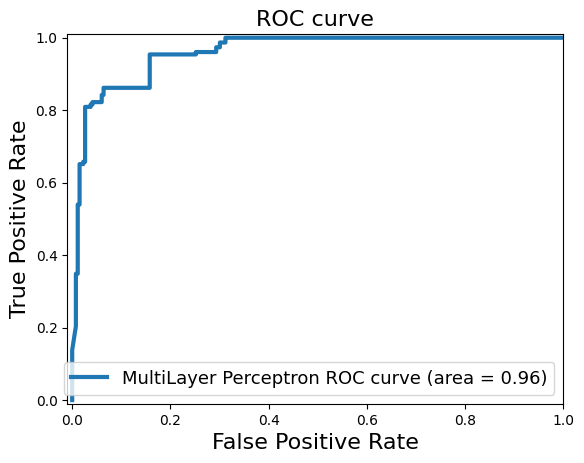

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
brfclf = RandomForestClassifier(n_estimators=100)
brfclf.fit(X_train, y_train)

y_score_mlp = brfclf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_mlp) #false positive and true positive values
roc_auc_mlp = auc(fpr_rf, tpr_rf)  

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_rf, tpr_rf, lw=3, label='MultiLayer Perceptron ROC curve (area = {:0.2f})'.format(roc_auc_mlp))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.show()


In [28]:
#export to csv 
test_result=pd.DataFrame({'PassengerId':passengerId,'Survived':brfclf.predict(X_test)})
test_result.to_csv("titanic_predictions.csv", index=False)